# Method 5 - Best Ideas Low Popularity

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns per Shumway, Szefler, Yuan 2009

%store -r exp_ret

valid_data = valid_data.merge(exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Filter Popularity

best_ideas['port_tilt_pct'] = best_ideas.groupby('datadate')['adj_target'].rank(pct=True)

popularity = best_ideas.groupby(['datadate', 'fsym_id'])['port_tilt_pct'].sum().reset_index()
popularity['median_port_tilt_pct'] = popularity.groupby('datadate')['port_tilt_pct'].transform('median')
popularity = popularity[popularity['port_tilt_pct'] < popularity['median_port_tilt_pct']]

best_ideas = best_ideas.merge(popularity[['datadate', 'fsym_id', 'median_port_tilt_pct']])

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

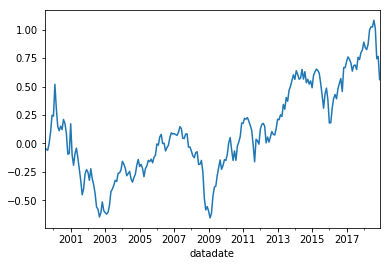

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.247474
2000-12-31   -0.269661
2001-12-31   -0.155212
2002-12-31   -0.468085
2003-12-31    0.872813
2004-12-31    0.120529
2005-12-31    0.043941
2006-12-31    0.206750
2007-12-31   -0.104965
2008-12-31   -0.541194
2009-12-31    0.928495
2010-12-31    0.375951
2011-12-31   -0.157767
2012-12-31    0.137861
2013-12-31    0.418529
2014-12-31   -0.033298
2015-12-31   -0.107753
2016-12-31    0.204920
2017-12-31    0.093267
2018-12-31   -0.143165
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     512.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          5.93e-113
Time:                        04:31:23   Log-Likelihood:                 503.48
No. Observations:                 234   AIC:                            -997.0
Df Residuals:                     229   BIC:                            -979.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.002      1.033      0.303      -0.002       0.006
mktrf          1.2662      0.053     23.867      0.000       1.162       1.371
me             0.5596      0.062      9.068      0.000       0.438       0.681
ia             0.0557      0.094      0.593      0.553      -0.129       0.240
roe           -0.9738      0.080    -12.129      0.000      -1.132      -0.816
==============================================================================
Omnibus:                       34.253   Durbin-Watson:                   2.209
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              180.998
Skew:                           0.350   Prob(JB):                     4.98e-40
Kurtosis:                       7.251   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     187.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.41e-71
Time:                        04:31:23   Log-Likelihood:                 503.48
No. Observations:                 234   AIC:                            -997.0
Df Residuals:                     229   BIC:                            -979.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.002      1.086      0.277      -0.002       0.006
mktrf          1.2662      0.064     19.729      0.000       1.140       1.392
me             0.5596      0.085      6.610      0.000       0.394       0.726
ia             0.0557      0.149      0.375      0.708      -0.236       0.347
roe           -0.9738      0.130     -7.503      0.000      -1.228      -0.719
==============================================================================
Omnibus:                       34.253   Durbin-Watson:                   2.209
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              180.998
Skew:                           0.350   Prob(JB):                     4.98e-40
Kurtosis:                       7.251   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     180.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.36e-69
Time:                        04:31:23   Log-Likelihood:                 503.48
No. Observations:                 234   AIC:                            -997.0
Df Residuals:                     229   BIC:                            -979.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.002      1.093      0.274      -0.002       0.006
mktrf          1.2662      0.065     19.513      0.000       1.139       1.393
me             0.5596      0.103      5.437      0.000       0.358       0.761
ia             0.0557      0.131      0.426      0.670      -0.200       0.312
roe           -0.9738      0.143     -6.816      0.000      -1.254      -0.694
==============================================================================
Omnibus:                       34.253   Durbin-Watson:                   2.209
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              180.998
Skew:                           0.350   Prob(JB):                     4.98e-40
Kurtosis:                       7.251   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     303.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.17e-98
Time:                        04:31:23   Log-Likelihood:                 472.91
No. Observations:                 234   AIC:                            -933.8
Df Residuals:                     228   BIC:                            -913.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.002      0.497      0.619      -0.003       0.006
mktrf          1.3633      0.061     22.456      0.000       1.244       1.483
smb            0.6097      0.080      7.612      0.000       0.452       0.768
hml            0.3242      0.094      3.432      0.001       0.138       0.510
rmw           -0.8193      0.107     -7.672      0.000      -1.030      -0.609
cma           -0.1275      0.136     -0.939      0.349      -0.395       0.140
==============================================================================
Omnibus:                      112.451   Durbin-Watson:                   2.142
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              873.642
Skew:                           1.707   Prob(JB):                    1.95e-190
Kurtosis:                      11.829   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     151.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.93e-70
Time:                        04:31:23   Log-Likelihood:                 472.91
No. Observations:                 234   AIC:                            -933.8
Df Residuals:                     228   BIC:                            -913.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.002      0.526      0.599      -0.003       0.005
mktrf          1.3633      0.067     20.286      0.000       1.232       1.495
smb            0.6097      0.106      5.770      0.000       0.403       0.817
hml            0.3242      0.116      2.803      0.005       0.098       0.551
rmw           -0.8193      0.150     -5.479      0.000      -1.112      -0.526
cma           -0.1275      0.239     -0.533      0.594      -0.597       0.341
==============================================================================
Omnibus:                      112.451   Durbin-Watson:                   2.142
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              873.642
Skew:                           1.707   Prob(JB):                    1.95e-190
Kurtosis:                      11.829   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     238.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.30e-88
Time:                        04:31:24   Log-Likelihood:                 472.91
No. Observations:                 234   AIC:                            -933.8
Df Residuals:                     228   BIC:                            -913.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.002      0.477      0.633      -0.003       0.006
mktrf          1.3633      0.068     20.010      0.000       1.230       1.497
smb            0.6097      0.112      5.445      0.000       0.390       0.829
hml            0.3242      0.110      2.949      0.003       0.109       0.540
rmw           -0.8193      0.162     -5.068      0.000      -1.136      -0.502
cma           -0.1275      0.241     -0.530      0.596      -0.599       0.344
==============================================================================
Omnibus:                      112.451   Durbin-Watson:                   2.142
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              873.642
Skew:                           1.707   Prob(JB):                    1.95e-190
Kurtosis:                      11.829   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     496.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.51e-111
Time:                        04:31:24   Log-Likelihood:                 500.17
No. Observations:                 234   AIC:                            -990.3
Df Residuals:                     229   BIC:                            -973.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.002     -0.272      0.786      -0.004       0.003
mktrf          1.3584      0.050     27.419      0.000       1.261       1.456
smb            1.0120      0.062     16.365      0.000       0.890       1.134
hml            0.0507      0.061      0.826      0.410      -0.070       0.172
umd           -0.4728      0.040    -11.731      0.000      -0.552      -0.393
==============================================================================
Omnibus:                       17.211   Durbin-Watson:                   2.299
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.863
Skew:                           0.046   Prob(JB):                     1.22e-12
Kurtosis:                       5.370   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     322.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.14e-93
Time:                        04:31:24   Log-Likelihood:                 500.17
No. Observations:                 234   AIC:                            -990.3
Df Residuals:                     229   BIC:                            -973.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.002     -0.305      0.760      -0.004       0.003
mktrf          1.3584      0.066     20.716      0.000       1.230       1.487
smb            1.0120      0.099     10.244      0.000       0.818       1.206
hml            0.0507      0.056      0.906      0.365      -0.059       0.160
umd           -0.4728      0.071     -6.657      0.000      -0.612      -0.334
==============================================================================
Omnibus:                       17.211   Durbin-Watson:                   2.299
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.863
Skew:                           0.046   Prob(JB):                     1.22e-12
Kurtosis:                       5.370   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     257.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.94e-83
Time:                        04:31:24   Log-Likelihood:                 500.17
No. Observations:                 234   AIC:                            -990.3
Df Residuals:                     229   BIC:                            -973.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.002     -0.329      0.743      -0.004       0.003
mktrf          1.3584      0.065     20.871      0.000       1.231       1.486
smb            1.0120      0.094     10.712      0.000       0.827       1.197
hml            0.0507      0.050      1.007      0.314      -0.048       0.149
umd           -0.4728      0.058     -8.099      0.000      -0.587      -0.358
==============================================================================
Omnibus:                       17.211   Durbin-Watson:                   2.299
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.863
Skew:                           0.046   Prob(JB):                     1.22e-12
Kurtosis:                       5.370   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     239.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.95e-55
Time:                        04:31:24   Log-Likelihood:                 232.83
No. Observations:                 120   AIC:                            -455.7
Df Residuals:                     115   BIC:                            -441.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0061      0.003      1.801      0.074      -0.001       0.013
mktrf          1.2501      0.092     13.658      0.000       1.069       1.431
me             0.4588      0.090      5.076      0.000       0.280       0.638
ia             0.1120      0.142      0.791      0.430      -0.168       0.392
roe           -1.1007      0.125     -8.785      0.000      -1.349      -0.853
==============================================================================
Omnibus:                        8.438   Durbin-Watson:                   2.254
Prob(Omnibus):                  0.015   Jarque-Bera (JB):               17.737
Skew:                          -0.002   Prob(JB):                     0.000141
Kurtosis:                       4.883   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     124.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           9.02e-41
Time:                        04:31:24   Log-Likelihood:                 232.83
No. Observations:                 120   AIC:                            -455.7
Df Residuals:                     115   BIC:                            -441.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0061      0.003      2.102      0.036       0.000       0.012
mktrf          1.2501      0.084     14.878      0.000       1.085       1.415
me             0.4588      0.102      4.499      0.000       0.259       0.659
ia             0.1120      0.183      0.613      0.540      -0.246       0.470
roe           -1.1007      0.133     -8.267      0.000      -1.362      -0.840
==============================================================================
Omnibus:                        8.438   Durbin-Watson:                   2.254
Prob(Omnibus):                  0.015   Jarque-Bera (JB):               17.737
Skew:                          -0.002   Prob(JB):                     0.000141
Kurtosis:                       4.883   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     127.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.80e-41
Time:                        04:31:24   Log-Likelihood:                 232.83
No. Observations:                 120   AIC:                            -455.7
Df Residuals:                     115   BIC:                            -441.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0061      0.002      2.461      0.014       0.001       0.011
mktrf          1.2501      0.087     14.375      0.000       1.080       1.421
me             0.4588      0.119      3.870      0.000       0.226       0.691
ia             0.1120      0.158      0.707      0.479      -0.198       0.422
roe           -1.1007      0.148     -7.428      0.000      -1.391      -0.810
==============================================================================
Omnibus:                        8.438   Durbin-Watson:                   2.254
Prob(Omnibus):                  0.015   Jarque-Bera (JB):               17.737
Skew:                          -0.002   Prob(JB):                     0.000141
Kurtosis:                       4.883   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     136.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.98e-46
Time:                        04:31:24   Log-Likelihood:                 215.50
No. Observations:                 120   AIC:                            -419.0
Df Residuals:                     114   BIC:                            -402.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0067      0.004      1.655      0.101      -0.001       0.015
mktrf          1.4364      0.112     12.824      0.000       1.214       1.658
smb            0.5139      0.127      4.051      0.000       0.263       0.765
hml            0.3508      0.155      2.257      0.026       0.043       0.659
rmw           -0.9002      0.183     -4.911      0.000      -1.263      -0.537
cma           -0.0633      0.201     -0.315      0.753      -0.461       0.335
==============================================================================
Omnibus:                       48.212   Durbin-Watson:                   2.270
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              173.364
Skew:                           1.389   Prob(JB):                     2.26e-38
Kurtosis:                       8.192   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     86.25
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.29e-37
Time:                        04:31:24   Log-Likelihood:                 215.50
No. Observations:                 120   AIC:                            -419.0
Df Residuals:                     114   BIC:                            -402.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0067      0.003      2.021      0.043       0.000       0.013
mktrf          1.4364      0.126     11.364      0.000       1.189       1.684
smb            0.5139      0.139      3.687      0.000       0.241       0.787
hml            0.3508      0.175      2.006      0.045       0.008       0.693
rmw           -0.9002      0.211     -4.269      0.000      -1.314      -0.487
cma           -0.0633      0.272     -0.232      0.816      -0.597       0.471
==============================================================================
Omnibus:                       48.212   Durbin-Watson:                   2.270
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              173.364
Skew:                           1.389   Prob(JB):                     2.26e-38
Kurtosis:                       8.192   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     121.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.00e-44
Time:                        04:31:24   Log-Likelihood:                 215.50
No. Observations:                 120   AIC:                            -419.0
Df Residuals:                     114   BIC:                            -402.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0067      0.003      1.974      0.048    4.59e-05       0.013
mktrf          1.4364      0.129     11.115      0.000       1.183       1.690
smb            0.5139      0.141      3.654      0.000       0.238       0.790
hml            0.3508      0.171      2.053      0.040       0.016       0.686
rmw           -0.9002      0.217     -4.153      0.000      -1.325      -0.475
cma           -0.0633      0.270     -0.234      0.815      -0.593       0.466
==============================================================================
Omnibus:                       48.212   Durbin-Watson:                   2.270
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              173.364
Skew:                           1.389   Prob(JB):                     2.26e-38
Kurtosis:                       8.192   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     228.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           9.66e-54
Time:                        04:31:24   Log-Likelihood:                 230.35
No. Observations:                 120   AIC:                            -450.7
Df Residuals:                     115   BIC:                            -436.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.003      0.867      0.388      -0.004       0.010
mktrf          1.4393      0.082     17.484      0.000       1.276       1.602
smb            1.0121      0.094     10.798      0.000       0.826       1.198
hml            0.0423      0.094      0.451      0.653      -0.144       0.228
umd           -0.4721      0.058     -8.157      0.000      -0.587      -0.357
==============================================================================
Omnibus:                        6.398   Durbin-Watson:                   2.477
Prob(Omnibus):                  0.041   Jarque-Bera (JB):                7.834
Skew:                          -0.292   Prob(JB):                       0.0199
Kurtosis:                       4.107   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     168.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.61e-47
Time:                        04:31:24   Log-Likelihood:                 230.35
No. Observations:                 120   AIC:                            -450.7
Df Residuals:                     115   BIC:                            -436.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.003      1.098      0.272      -0.002       0.008
mktrf          1.4393      0.106     13.525      0.000       1.231       1.648
smb            1.0121      0.137      7.389      0.000       0.744       1.281
hml            0.0423      0.082      0.519      0.603      -0.117       0.202
umd           -0.4721      0.084     -5.599      0.000      -0.637      -0.307
==============================================================================
Omnibus:                        6.398   Durbin-Watson:                   2.477
Prob(Omnibus):                  0.041   Jarque-Bera (JB):                7.834
Skew:                          -0.292   Prob(JB):                       0.0199
Kurtosis:                       4.107   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     152.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.25e-45
Time:                        04:31:24   Log-Likelihood:                 230.35
No. Observations:                 120   AIC:                            -450.7
Df Residuals:                     115   BIC:                            -436.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.002      1.350      0.177      -0.001       0.007
mktrf          1.4393      0.105     13.764      0.000       1.234       1.644
smb            1.0121      0.127      7.940      0.000       0.762       1.262
hml            0.0423      0.080      0.531      0.596      -0.114       0.199
umd           -0.4721      0.066     -7.140      0.000      -0.602      -0.343
==============================================================================
Omnibus:                        6.398   Durbin-Watson:                   2.477
Prob(Omnibus):                  0.041   Jarque-Bera (JB):                7.834
Skew:                          -0.292   Prob(JB):                       0.0199
Kurtosis:                       4.107   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     411.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.75e-65
Time:                        04:31:24   Log-Likelihood:                 307.69
No. Observations:                 114   AIC:                            -605.4
Df Residuals:                     109   BIC:                            -591.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0016      0.002     -0.990      0.325      -0.005       0.002
mktrf          1.2379      0.049     25.294      0.000       1.141       1.335
me             0.8193      0.076     10.843      0.000       0.670       0.969
ia            -0.0049      0.105     -0.046      0.963      -0.213       0.203
roe           -0.6453      0.092     -7.007      0.000      -0.828      -0.463
==============================================================================
Omnibus:                       16.765   Durbin-Watson:                   2.128
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               22.459
Skew:                           0.764   Prob(JB):                     1.33e-05
Kurtosis:                       4.547   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     332.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.57e-60
Time:                        04:31:24   Log-Likelihood:                 307.69
No. Observations:                 114   AIC:                            -605.4
Df Residuals:                     109   BIC:                            -591.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0016      0.001     -1.200      0.230      -0.004       0.001
mktrf          1.2379      0.069     17.846      0.000       1.102       1.374
me             0.8193      0.086      9.516      0.000       0.651       0.988
ia            -0.0049      0.130     -0.037      0.970      -0.260       0.251
roe           -0.6453      0.109     -5.910      0.000      -0.859      -0.431
==============================================================================
Omnibus:                       16.765   Durbin-Watson:                   2.128
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               22.459
Skew:                           0.764   Prob(JB):                     1.33e-05
Kurtosis:                       4.547   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     334.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.12e-60
Time:                        04:31:24   Log-Likelihood:                 307.69
No. Observations:                 114   AIC:                            -605.4
Df Residuals:                     109   BIC:                            -591.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0016      0.001     -1.195      0.232      -0.004       0.001
mktrf          1.2379      0.072     17.303      0.000       1.098       1.378
me             0.8193      0.094      8.733      0.000       0.635       1.003
ia            -0.0049      0.151     -0.032      0.974      -0.301       0.291
roe           -0.6453      0.114     -5.684      0.000      -0.868      -0.423
==============================================================================
Omnibus:                       16.765   Durbin-Watson:                   2.128
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               22.459
Skew:                           0.764   Prob(JB):                     1.33e-05
Kurtosis:                       4.547   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     278.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.66e-60
Time:                        04:31:24   Log-Likelihood:                 299.23
No. Observations:                 114   AIC:                            -586.5
Df Residuals:                     108   BIC:                            -570.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0032      0.002     -1.758      0.082      -0.007       0.000
mktrf          1.2712      0.051     25.169      0.000       1.171       1.371
smb            0.7899      0.082      9.634      0.000       0.627       0.952
hml            0.3220      0.105      3.079      0.003       0.115       0.529
rmw           -0.5402      0.128     -4.219      0.000      -0.794      -0.286
cma           -0.2047      0.163     -1.259      0.211      -0.527       0.117
==============================================================================
Omnibus:                        3.297   Durbin-Watson:                   2.046
Prob(Omnibus):                  0.192   Jarque-Bera (JB):                3.016
Skew:                           0.398   Prob(JB):                        0.221
Kurtosis:                       3.024   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     170.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.29e-49
Time:                        04:31:24   Log-Likelihood:                 299.23
No. Observations:                 114   AIC:                            -586.5
Df Residuals:                     108   BIC:                            -570.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0032      0.002     -1.915      0.056      -0.006    7.48e-05
mktrf          1.2712      0.058     21.742      0.000       1.157       1.386
smb            0.7899      0.069     11.526      0.000       0.656       0.924
hml            0.3220      0.114      2.833      0.005       0.099       0.545
rmw           -0.5402      0.114     -4.747      0.000      -0.763      -0.317
cma           -0.2047      0.213     -0.961      0.337      -0.622       0.213
==============================================================================
Omnibus:                        3.297   Durbin-Watson:                   2.046
Prob(Omnibus):                  0.192   Jarque-Bera (JB):                3.016
Skew:                           0.398   Prob(JB):                        0.221
Kurtosis:                       3.024   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     172.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           9.18e-50
Time:                        04:31:24   Log-Likelihood:                 299.23
No. Observations:                 114   AIC:                            -586.5
Df Residuals:                     108   BIC:                            -570.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0032      0.002     -1.868      0.062      -0.006       0.000
mktrf          1.2712      0.058     21.900      0.000       1.157       1.385
smb            0.7899      0.068     11.580      0.000       0.656       0.924
hml            0.3220      0.116      2.769      0.006       0.094       0.550
rmw           -0.5402      0.101     -5.335      0.000      -0.739      -0.342
cma           -0.2047      0.243     -0.843      0.399      -0.680       0.271
==============================================================================
Omnibus:                        3.297   Durbin-Watson:                   2.046
Prob(Omnibus):                  0.192   Jarque-Bera (JB):                3.016
Skew:                           0.398   Prob(JB):                        0.221
Kurtosis:                       3.024   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     396.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.94e-64
Time:                        04:31:24   Log-Likelihood:                 305.68
No. Observations:                 114   AIC:                            -601.4
Df Residuals:                     109   BIC:                            -587.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0032      0.002     -1.892      0.061      -0.007       0.000
mktrf          1.2709      0.047     26.925      0.000       1.177       1.364
smb            0.9377      0.074     12.740      0.000       0.792       1.084
hml            0.1990      0.076      2.625      0.010       0.049       0.349
umd           -0.3542      0.057     -6.194      0.000      -0.468      -0.241
==============================================================================
Omnibus:                        2.561   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.278   Jarque-Bera (JB):                1.994
Skew:                           0.241   Prob(JB):                        0.369
Kurtosis:                       3.434   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     268.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.70e-55
Time:                        04:31:24   Log-Likelihood:                 305.68
No. Observations:                 114   AIC:                            -601.4
Df Residuals:                     109   BIC:                            -587.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0032      0.001     -2.497      0.013      -0.006      -0.001
mktrf          1.2709      0.055     22.955      0.000       1.162       1.379
smb            0.9377      0.057     16.419      0.000       0.826       1.050
hml            0.1990      0.082      2.416      0.016       0.038       0.360
umd           -0.3542      0.067     -5.312      0.000      -0.485      -0.224
==============================================================================
Omnibus:                        2.561   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.278   Jarque-Bera (JB):                1.994
Skew:                           0.241   Prob(JB):                        0.369
Kurtosis:                       3.434   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     283.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.24e-56
Time:                        04:31:24   Log-Likelihood:                 305.68
No. Observations:                 114   AIC:                            -601.4
Df Residuals:                     109   BIC:                            -587.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0032      0.001     -2.553      0.011      -0.006      -0.001
mktrf          1.2709      0.054     23.737      0.000       1.166       1.376
smb            0.9377      0.053     17.754      0.000       0.834       1.041
hml            0.1990      0.076      2.635      0.008       0.051       0.347
umd           -0.3542      0.073     -4.848      0.000      -0.497      -0.211
==============================================================================
Omnibus:                        2.561   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.278   Jarque-Bera (JB):                1.994
Skew:                           0.241   Prob(JB):                        0.369
Kurtosis:                       3.434   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""